In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from config import SEED, FONTSZ, COLOR_G, COLOR_X, COLOR_RA, COLOR_FIT, COLOR_FOOD, COLOR_OGTT

In [147]:
t_start = 5
t_end = 60*12#700
t_points = 1000
t_span = [t_start, t_end]
t_eval = np.linspace(t_start, t_end, t_points)

params = {
    'p1': 10.025, #'[1/min]',
    'p2': 4.012, #'[1/min]',
    'SG': 10, # '[10^(-4)1/min per mg/dL]
    'alpha': 0.1, #'[dL/mg]'
    'beta': 5, #'[min]'
    'T1': 30+120, #'[min]'
    'T2': 100+120, #'[min]'
    'W1': 0.5,
    'W2': 0.5,
    'RH': 0.7,
    'V': 1.45, #'[dL/kg]',
    'lambda': 0,
    'f': 0.9,
    'D': 75_000/75, #'[mg/kg]',
    'A': 900, #'[mg/kg]',
    'Gb': 120, #'[mg/dL]',
    'G0': 121, #'[mg/dL]',
    'X0': 0, #'[1/min]',
}

In [148]:
dynamic_vars = ['G', 'X']
dynamic_vars_labels = ['Glucose values', 'X values']
dynamic_vars_colors = [COLOR_G, COLOR_X]
# inital conditions
y0 = [params['G0'], params['X0']]

# ode function
def ODE_func(t, ys, Ra, params):
    Gb = params['Gb']
    p1 = params['p1']
    alpha = params['alpha']
    beta = params['beta']
    p2 = params['p2']
    SG = params['SG']

    G, X = ys
    dG = -G*X - p1*(G-Gb) + Ra(t)
    # Zpos = 1+np.exp(-alpha*(G-Gb))
    Zpos = 1
    Z = (G-Gb)/Zpos + beta*Ra(t)
    dX = -p2*(X-SG*Z)
    return [dG, dX]
ode_func = ODE_func

# input function
def Ra_func(t, params):
    # Unpack model params
    V = params['V']
    A = params['A']
    RH = params['RH']
    T1 = params['T1']
    W1 = params['W1']
    T2 = params['T2']
    W2 = params['W2']

    def f_LN(t, T, W):
        return (np.exp(-((np.log(t/T)-W/2)**2)/W))/(t*np.sqrt(np.pi*W))
        
    Ra_value = A*(1-RH)*f_LN(t, T1, W1) + A*(RH)*f_LN(t, T2, W2)
    Ra_value = Ra_value / V
    Ra = interp1d(x=t, y=Ra_value, bounds_error=False)
    return Ra


In [149]:
def run_ode_sim():
    # Solve ODE
    sol = solve_ivp(ode_func, t_span=t_span, y0=y0, t_eval=t_eval,
                    args=(Ra, params), dense_output=True, method='Radau')
    # Output to pd Dataframe
    z = sol.sol(t_eval).T
    dynamics_df = pd.DataFrame(z, columns=dynamic_vars)
    dynamics_df['Ra'] = Ra(t_eval)
    dynamics_df['t'] = t_eval
    return dynamics_df

def simulate():
    # Compute Ra input
    Ra = Ra_func(t_eval, params)
    # Solve dynamics
    dynamics_df = run_ode_sim()

def plot_dynamic_vars():
    # Plot outputs
    n_vars = len(dynamic_vars)+1
    fig, axes = plt.subplots(n_vars, 1, figsize=(6, 0.6+n_vars), sharex=True)
    # Plot Ra input
    ax = axes[0]
    ax.plot(t_eval, dynamics_df['Ra'],
            lw=1, color=COLOR_RA, alpha=0.5, label='Ra')
    ax.fill_between(
        t_eval, 0, dynamics_df['Ra'], color=COLOR_RA, alpha=0.4)
    ax.set(ylabel='Ra(t)')
    ax.grid()
    # plot dynamic vars
    for i, var in enumerate(dynamic_vars):
        ax = axes[i+1]
        ax.plot(t_eval, dynamics_df[var], ls='-', lw=4,
                color=dynamic_vars_colors[i], alpha=0.5, label=dynamic_vars_labels[i])
        ax.set(ylabel=f'{var}(t)')
        ax.grid()
    fig.tight_layout()
    return fig, axes

In [150]:
# Ra = Ra_func(t_eval, params)
# plt.plot(Ra(t_eval))

In [151]:
dynamics_df = run_ode_sim()

(<Figure size 432x259.2 with 3 Axes>,
 array([<AxesSubplot:ylabel='Ra(t)'>, <AxesSubplot:ylabel='G(t)'>,
        <AxesSubplot:ylabel='X(t)'>], dtype=object))

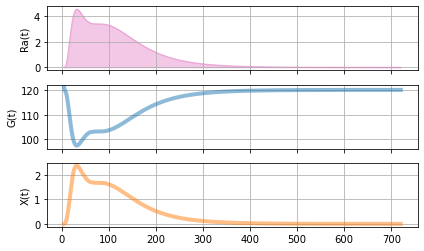

In [152]:
plot_dynamic_vars()

In [52]:
dynamics_df.head(30)

,G,X,Ra,t
0,91.000000,0.000000,0.007112,5.000000
1,95.917380,-0.137704,0.017901,5.715716
2,113.665722,-0.335722,0.038071,6.431431
3,132.450510,0.130909,0.071320,7.147147
4,106.529477,0.288363,0.121097,7.862863
5,91.791983,0.165617,0.190198,8.578579
6,82.828677,0.162248,0.280492,9.294294
7,72.746267,0.250597,0.392806,10.010010
8,58.579009,0.423256,0.526925,10.725726
9,41.144342,0.672179,0.681691,11.441441
